# Analog to digital conversion

The real world tends to result in analog signals. We need to convert these to digital numbers in order to analyse the results of experiments using a computer.

E.g., suppose that you have a voltage that ranges between 0 and 10V. How do you represent this voltage as a digital number?

Converting from analog to digital implicitly means that there is some minimum delta in the analog signal that corresponds to a change of 1 in the digital number. So, one of the first decisions to make is: *what is the minimum delta that you need to resolve?* E.g., if the analog signal 0.00V is assigned the digital number 0, and your resolution is 0.01V, then 10.00 will correspond to a digital number 1000.

Computers use binary (base 2) arithmetic internally, so it makes sense to think of *the number of bits (binary digits)* for an analog to digital conversion. E.g., $1024=2^{10}$ so an analog to digital conversion that ranges from 0 to 1000 requires a 10 bit binary number to represent the result. In fact, with 10 bits we can range from 0 (binary 0000000000) to 1023 (binary 1111111111). 

To represent negative numbers we often use the most significant bit (MSB) as a sign bit. However, noting that 1000000000 would be the same as 0000000000, thereby wasting a number, we use so-called "2s complement binary", where, e.g., 1000000000 is -512, 1111111111 is -1, and 0000000000 is zero, and 0111111111 is +511.

## Types of analog to digital converters

### Flash converters

Flash converters are the easiest to understand. The input analog voltage is compared to voltages generated using a resistive voltage divider. The comparisons are done in parallel (i.e., all at the same time) by a series of voltage comparators (these are the triangular symbols in the circuit diagram below; they produce a 0 or 1 output depending on whether the input voltage connected to the +ve terminal is less than or greater than the comparison voltage on the -ve terminal). You need one comparator for every possible digital number. The output of the comparators is then examined by a logic circuit to generate the binary number.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/adc-flash.gif)

In practice, the logic circuit is a bit smarter than just detecting the highest numbered comparator that has a 1 output. For example:

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/Flash_ADC.png)

Flash converters can be very fast (since $2^n$ comparisons are made in the same time it takes to make one comparison), but also relatively expensive (since you need $2^n$ comparators). They tend to be used when very high-speed, but low-resolution, digitisation is needed.

### Successive approximate ADC

The following figure (by White Flye - Own work, CC BY-SA 2.5) shows a successive approximation ADC.

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/SA_ADC_block_diagram.png)

Vin in the input voltage to be digitised. Vref is a stable reference voltage that sets the maximum output of the DAC. SAR is the successive approximation register. S/H is a sample and hold amplifier. DAC is a digital to analog converter. "Clock" is a square wave oscillation that sets the time interval for one comparison between the sampled input signal and the DAC output.

See if you can work out how it works.

For notes on analog to digital conversion [read this](http://www.analog.com/media/en/training-seminars/design-handbooks/Data-Conversion-Handbook/Chapter2.pdf).

### Some interesting aspects of ADCs

Discussed in lectures but not described in these notes:

- monotonicity; important for servo systems
- bit errors can introduce large errors
- subtle errors that correlate with certain digital outputs. See [this very interesting paper](https://arxiv.org/pdf/1802.06914.pdf) on how this can affect astronomical CCD images.

### ADC trade-offs

Generally speaking, there is a trade-off between the number of bits of precision and the speed of the ADC. E.g., if you want GHz sampling, you are probably looking at 8-bit sampling; if you want 30-bit precision, then you may have to wait a second per sample. If you have lots of dollars available, then these boundaries can be pushed.

### A real-world example: the CAN Inspector

For my instrumentation work in Antarctica I needed to be able to verify the health of the Controller Area Network (CAN) bus upon which the observatory depends. The CAN bus transmits data on two wires (a ground wire is also needed, to provide a reference voltage level). CAN is cleverly designed so that either one of the two data wires can be cut, or shorted to 0V or +5V, and the bus will still work perfectly. However, this ability to keep operating can lull you into a false sense of security: what happens if the bus is already working at the limits of its self-correction? Then, any additional problem will cause a failure. So, it is essential to be able to recognise when the bus has been compromised. Hence the CAN Inspector, which is basically a digital oscilloscope that monitors the data wires, and transmits a voltage versus time graph to a monitoring computer on the CAN bus itself. The CAN Inspector also allows you to diagnose problems such as a missing terminating resistor, that can cause reflections of the electrical signals. 

An immediate problem to overcome with the CAN Inspector design was that the CAN bus bandwidth is rather slow (100 kbps in my application), whereas to diagnose termination issues you need to digitise at more like 1 Gbps. Fortunately there are nice ADCs available such as the 8-bit, 200 MHz ADC08B200 that has a built-in 1024 byte buffer. Once triggered, the ADC08B200 can slurp in 1024 bytes of samples, which can then be leisurely transmitted across the CAN bus at a later time.

The image below shows the CAN Inspector. The ADC is part U3. The CAN connector is J1 at top right. The microprocessor is the biggest integrated circuit (U14).

![](http://mcba11.phys.unsw.edu.au/~mcba/phys3112/canI.jpg)


### Gray codes

Gray codes are worth knowing about, and can have applications for ADCs. A gray code assigns a unique binary number to each decimal, such that if you move from one code to the next, only a single bit will change. This avoids 'glitch' states from physical systems if you sample a binary number when two bits are in the process of changing simultaneously.

E.g., here is a 4-bit Gray code:

| Decimal | Binary | Gray |
|---------|--------|------|
| 0|0000|0000|
| 1|0001|0001|
| 2|0010|0011|
| 3|0011|0010|
| 4|0100|0110|
| 5|0101|0111|
| 6|0110|0101|
| 7|0111|0100|
| 8|1000|1100|
| 9|1001|1101|
|10|1010|1111|
|11|1011|1110|
|12|1100|1010|
|13|1101|1011|
|14|1110|1001|
|15|1111|1000|
--------------



### Adding noise to improve resolution

Suppose that you have a perfect 8-bit ADC, and a perfectly stable analog signal. The ADC will then always give the same digital number. Now, if you add a bit or two of gaussian noise to the signal, the ADC output will vary  by a bit or two. Why would you want to do that? Well, if you examine a large number of samples, you can fit a gaussian profile to the distribution, and find the centre of the gaussian to much less that one bit of precision. 

So, somewhat paradoxically, by adding noise to your signal, you have improved the precision (and possibly the accuracy) of the digital conversion. 

Whether this technique is a good idea in practice depends on many details. E.g., if you want the best estimate of a rapidly varying signal, you are better off not adding noise. But if the ADC is much faster than the signal variations of interest, then adding noise can effectively give you additional bits of resolution. As an example, I once used this technique to increase the precision of a temperature measurement, and was able to divide each least significant bit (LSB) of an ADC by 64 (i.e., I added an additional 6 bits of resolution to an 8-bit ADC). While I make no claims about the *accuracy* of the resulting digital temperature, the extra *precision* was very useful in detecting temperature trends, which is what I was particularly interested in.

One question: how to you go about adding noise to a signal from an experiment? One way would be to use a summing amplifier, and add the output from a digital-to-analog-converter (DAC) driven by software.

The following code allows you to explore the effect of adding noise to a signal, prior to digitisation and averaging. Try changing the first two of the parameters at the beginning (`adc_samples` and `noise_amplitude`).

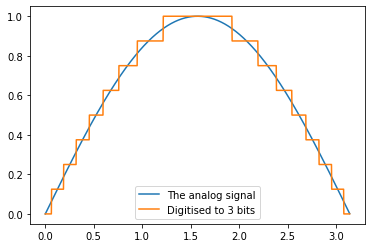

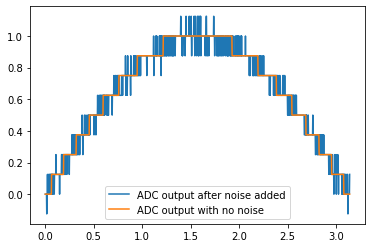

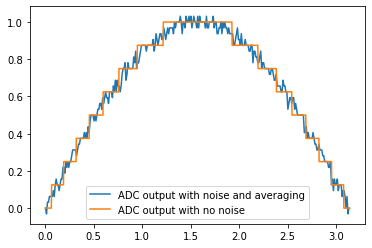

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# How many ADC samples we should average:

adc_samples = 4

# How much noise we should add to the input signal, the signal
# amplitude is 1.0. The noise should be at least 1 bit in amplitude.

noise_amplitude = 0.04

# The number of bits that our simulated ADC has:

adc_bits = 3

# Form an array of times at which we will sample the signal.

t = np.arange(0, np.pi, 0.01 / adc_samples)

# Here is our signal. Just a sine wave with unit amplitude. We
# are following it for half a period.

f = np.sin(t)

# Simulate an observation of the signal with the ADC, with no averaging.
# np.rint returns the nearest integer to each floating-point number.

fadc = np.rint(f * 2**adc_bits) / 2**adc_bits

# Now add some gaussian noise to the signal.

f_plus_noise = f + noise_amplitude * np.random.randn(len(t))

# And observe the noisy signal with the ADC, with no averaging.

fadc_plus_noise = np.rint(f_plus_noise * 2**adc_bits) / 2**adc_bits

# Now average the ADC output over adc_samples samples.

# j is a counter that will go from 0 to adc_samples.
# sum is used to compute the average.

j = 0
sum = 0.0

# Arrays to hold the averaged samples, and the time mid-points.

fs = np.empty([len(t)//adc_samples])
ts = np.empty([len(t)//adc_samples])

# Now loop over all the times, averaging as we go.

for i in range(len(t)):
    sum += fadc_plus_noise[i]
    j += 1
    if j == adc_samples:
        fs[i//adc_samples] = sum / adc_samples
        ts[i//adc_samples] = t[i - adc_samples//2]
        j = 0
        sum = 0.0
        
# Finally, plot the results.
    
plt.plot(t, f)
plt.plot(t, fadc)
plt.legend(('The analog signal', 
            'Digitised to ' + str(adc_bits) + ' bits'), 
           loc='lower center')
plt.show()

plt.plot(t, fadc_plus_noise)
plt.plot(t, fadc)
plt.legend(('ADC output after noise added', 
            'ADC output with no noise'), loc='lower center')
plt.show()

plt.plot(ts, fs)
plt.plot(t, fadc)
plt.legend(('ADC output with noise and averaging', 
            'ADC output with no noise'), loc='lower center')
plt.show()
